In [ ]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [ ]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [ ]:
from openslide import open_slide, __library_version__ as openslide_lib_version, __version__ as openslide_version

import numpy as np
import random, os, glob, time
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator
from tensorflow.keras.layers import Dense, concatenate, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib.colors import Normalize
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    """ Read a region from the slide
    Return a numpy RBG array
    """
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    """ Return tissue pixels for an image
    """
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  
def apply_mask(im, mask, color=(1,0,0)):
    """ Return the mask as an image
    """
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked


In [ ]:
def display_single(slide_path,tumor_mask_path,level):
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                              slide.level_dimensions[i], 
                                                              slide.level_downsamples[i]))

  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

67 num_of_all_data
21 num_of_images
21 num_of_masks
['tumor_001.tif', 'tumor_002.tif', 'tumor_005.tif', 'tumor_012.tif', 'tumor_016.tif', 'tumor_019.tif', 'tumor_023.tif', 'tumor_031.tif', 'tumor_035.tif', 'tumor_057.tif', 'tumor_059.tif', 'tumor_064.tif', 'tumor_075.tif', 'tumor_078.tif', 'tumor_081.tif', 'tumor_084.tif', 'tumor_091.tif', 'tumor_094.tif', 'tumor_096.tif', 'tumor_110.tif', 'tumor_101.tif']
Read WSI from /content/drive/My Drive/Colab Notebooks/final_project/image/tumor_094.tif with width: 118784, height: 100352
Read tumor mask from /content/drive/My Drive/Colab Notebooks/final_project/mask/tumor_094_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (118784, 100352) downsample factor 1
Level 1, dimensions: (59392, 50176) downsample factor 2
Level 2, dimensions: (29696, 25088) downsample factor 4
Level 3, dimensions: (14848, 12544) downsample factor 8
Level 4, dimensions: (7424, 6272) downsample factor 16
Level 5, dimensions: (3712, 3136) downsample factor 32
Level

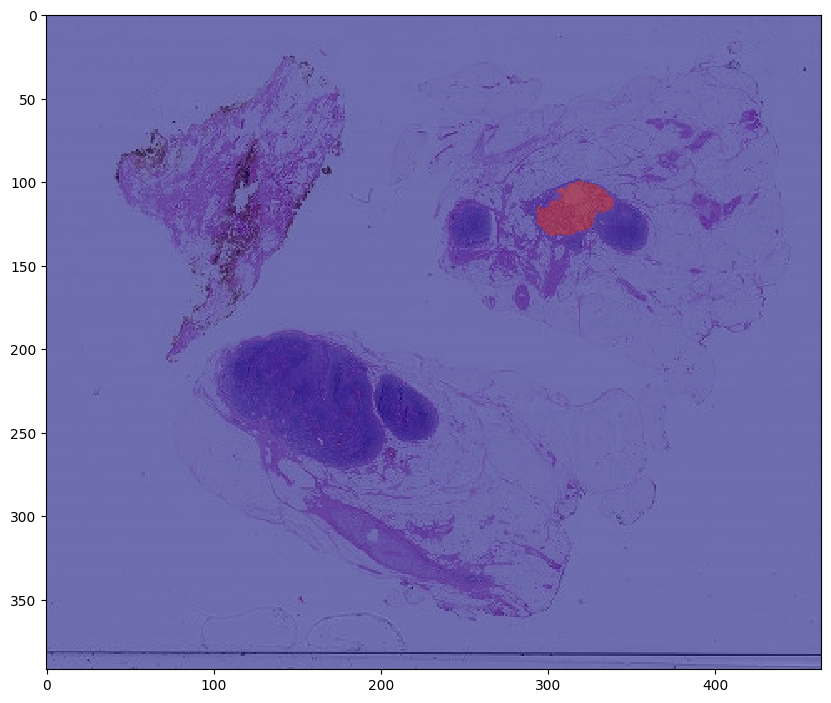

In [ ]:
work_space = "/content/drive/My Drive/Colab Notebooks/final_project"
image_path = os.path.join(work_space,"image/")
mask_path = os.path.join(work_space,"mask/")
data_path = os.path.join(work_space,"data/")


print(len(os.listdir(data_path)),"num_of_all_data")
print(len(os.listdir(image_path)),"num_of_images")
print(len(os.listdir(mask_path)),"num_of_masks")
# by inspection, delete No.38 file
if os.path.exists(os.path.join(image_path,"tumor_038.tif")):
  os.remove(os.path.join(image_path,"tumor_038.tif"))
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
print(image_list)
display_single(os.path.join(image_path,image_list[17]),os.path.join(mask_path,mask_list[17]),level=8)

In [ ]:
# delete all weight
origin = os.listdir("/content/")
for each in origin:
  print(each)
  if "hdf5" in each:
    os.remove(os.path.join("/content/",str(each)))

.config
multi-input_my-conv-base_lev36_lev3_patches_016_cancer-False.pdf
multi-input_my-conv-base_lev14_lev4_patches_019_cancer-True.pdf
multi-input_my-conv-base_lev25_lev2_patches_081_cancer-True.pdf
multi-input_my-conv-base_lev35_lev5_patches_101_cancer-False.pdf
multi-input_my-conv-base_lev25_lev2_patches_101_cancer-True.pdf
multi-input_my-conv-base_lev36_lev6_patches_019_cancer-False.pdf
multi-input_my-conv-base_lev35_lev3_patches_101_cancer-True.pdf
multi-input_my-conv-base_lev24_lev4_patches_019_cancer-False.pdf
multi-input_my-conv-base_lev14_lev1_patches_081_cancer-True.pdf
multi-input_my-conv-base_lev35_lev5_patches_101_cancer-True.pdf
multi-input_my-conv-base_lev14_lev1_patches_081_cancer-False.pdf
multi-input_my-conv-base_lev25_lev5_patches_016_cancer-False.pdf
multi-input_my-conv-base_lev25_lev2_patches_016_cancer-False.pdf
multi-input_my-conv-base_lev24_lev2_patches_023_cancer-True.pdf
multi-input_my-conv-base_lev36_lev6_patches_016_cancer-True.pdf
multi-input_my-conv-base_

In [ ]:
def plot_patch_triplet(lev, patch_centre, patch_image, patch_mask, patch_tissue, figname, f_num):
  patch_size = patch_image.shape[0]
  offset = int((patch_size-patch_centre)/2)
  tissue_ratio = np.sum(patch_tissue[:,:,0])/(patch_size**2)
  fig, axes = plt.subplots(1,3, figsize=(15,5))
  cmap = plt.cm.viridis
  v_min, v_max = 0, 1
  colors = Normalize(v_min, v_max)(patch_mask)
  colors = cmap(colors)
  colors[..., -1] = patch_mask
  a = axes[0]
  a.imshow(patch_image)
  a.set_title('Slide %s, level: %d' % (f_num, lev))
  a.grid(False)
  a = axes[1]
  a.imshow(patch_image)
  a.grid(False)
  a.imshow(colors, cmap='viridis', vmin=v_min, vmax=v_max, alpha=0.8)
  a.plot([offset, offset+patch_centre, offset+patch_centre, offset, offset],
                [offset, offset, offset+patch_centre, offset+patch_centre, offset], 'r')
  a.set_title('Cancer is yellow: if in red square - label 1')
  a = axes[2]
  a.imshow(patch_tissue, cmap='plasma', vmin=0, vmax=1), axes[2].grid(False)
  a.imshow(colors, cmap='viridis', vmin=v_min, vmax=v_max, alpha=0.5)
  a.set_title('Tissue ratio: ' + str(round(tissue_ratio,2)))
  
  plt.show()
  fig.savefig(figname+'.pdf', bbox_inches='tight')

In [ ]:
def get_patches(slide, tumor_mask, lev, x0, y0, patch_size):
  
  downsample_factor = 2**lev
  new_x = x0-(patch_size//2)*downsample_factor
  new_y = y0-(patch_size//2)*downsample_factor
  patch_image = read_slide(slide,
                            x = new_x,
                            y = new_y, 
                            level = lev,
                            width = patch_size,
                            height = patch_size)
  patch_mask = read_slide(tumor_mask,
                          x = new_x,
                          y = new_y, 
                          level = lev,
                          width = patch_size,
                          height = patch_size)
  patch_mask = patch_mask[:,:,0]
  
  # make tissue mask
  tissue_pixels = find_tissue_pixels(patch_image)
  patch_tissue = apply_mask(patch_image, tissue_pixels)
  
  return patch_image, patch_mask, patch_tissue

In [ ]:
def check_patch_centre(patch_mask, patch_centre):
  patch_size = patch_mask.shape[0]
  offset = int((patch_size-patch_centre)/2)
  sum_cancers = np.sum(patch_mask[offset:offset+patch_centre, offset:offset+patch_centre])
  
  return sum_cancers>0

In [ ]:
def collect_patches(img_list, lev1, lev2, num_per_img, patch_size, patch_centre):
  patch_images_lev1 = []
  patch_images_lev2 = []
  patch_labels = []

  for i, f_num in enumerate(img_list):
      num_cancer = 0
      num_health = 0
      slide_path = image_path+'tumor_'+f_num+'.tif'
      tumor_mask_path = mask_path+'tumor_'+f_num+'_mask.tif'
      slide = open_slide(slide_path)
      tumor_mask = open_slide(tumor_mask_path)
      slide_image = read_slide(slide, 
                            x=0, 
                            y=0, 
                            level=4, 
                            width=slide.level_dimensions[4][0], 
                            height=slide.level_dimensions[4][1])

      mask_image = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=4, 
                          width=tumor_mask.level_dimensions[4][0], 
                          height=tumor_mask.level_dimensions[4][1])

      mask_image = mask_image[:,:,0]

      # get a list of tumor pixels at level 4
      mask_lev_4_cancer = np.nonzero(mask_image)

      # make a healthy tissue mask by subtracting tumor mask from tissue mask
      tissue_pixels = find_tissue_pixels(slide_image)
      tissue_regions = apply_mask(slide_image, tissue_pixels)

      mask_health = tissue_regions[:,:,0]-mask_image
      mask_health = mask_health>0
      mask_health = mask_health.astype('int')

      # get a list of healthy pixels at level 4
      mask_lev_4_health = np.nonzero(mask_health)

      print()
      print(f_num, len(mask_lev_4_cancer[0])//(patch_size**2), len(mask_lev_4_health[0])//(patch_size**2))
      
      # -------------------------------------------------------------
      # extract TUMOR patches

      # get a random sample of tumor pixels 
      # Note: did random.sample here rather than random.choice inside the while loop because os speed
      sample_cancer = random.sample(list(zip(mask_lev_4_cancer[1], mask_lev_4_cancer[0])), 500)

      c = 0

      # continue until enough patches extracted
      while num_cancer<num_per_img:
          c += 1
          if c%10==0:
              print(c, end=', ')

          # get the next pixel from the sample - coordinates at level 4
          (x4, y4) = sample_cancer[c]

          # convert level 4 coordinates to level 0
          x0 = x4*(2**4)
          y0 = y4*(2**4)
          
          # extract patches at lev1 CENTERED at that pixel
          patch_image_lev1, patch_mask_lev1, patch_tissue_lev1 = \
          get_patches(slide, tumor_mask, lev1, x0, y0, patch_size)

          # calc tissue ratio in that patch
          tissue_ratio = np.sum(patch_tissue_lev1[:,:,0])/(patch_size**2)

          # double-check if the patch has tumor
          has_cancer = check_patch_centre(patch_mask_lev1, patch_centre)

          # if it has more than 50% tissue and has tumor
          if (tissue_ratio>0.5) & has_cancer:

              # collect lev1 patch
              num_cancer += 1
              patch_images_lev1.append(patch_image_lev1)
              patch_labels.append(1)

              # extract a patch at lev2 (zoomed-out) ceneterd at the same pixel
              patch_image_lev2, patch_mask_lev2, patch_tissue_lev2 = \
              get_patches(slide, tumor_mask, lev2, x0, y0, patch_size)

              # collect lev2 patch
              patch_images_lev2.append(patch_image_lev2)

              # plot the last patches for both levels
              if len(patch_labels)%num_per_img==0:
                  figname = model_name+'_lev'+str(lev1)+'_patches_'+f_num+'_cancer-'+str(has_cancer)
                  plot_patch_triplet(lev1, patch_centre, patch_image_lev1, patch_mask_lev1, patch_tissue_lev1, figname, f_num)
                  figname = model_name+'_lev'+str(lev2)+'_patches_'+f_num+'_cancer-'+str(has_cancer)
                  plot_patch_triplet(lev2, patch_centre, patch_image_lev2, patch_mask_lev2, patch_tissue_lev2, figname, f_num)

      print("cancer images collection completed")
      # get a random sample of healthy pixels 
      sample_health = random.sample(list(zip(mask_lev_4_health[1], mask_lev_4_health[0])), 500)

      c = 0

      # get healthy images
      while num_health<num_per_img:
          c += 1
          if c%10==0:
              print(c, end=', ')
          (x4, y4) = sample_health[c]
          x0 = x4*(2**4)
          y0 = y4*(2**4)
          patch_image_lev1, patch_mask_lev1, patch_tissue_lev1 = \
          get_patches(slide, tumor_mask, lev1, x0, y0, patch_size)
          tissue_ratio = np.sum(patch_tissue_lev1[:,:,0])/(patch_size**2)
          has_cancer = check_patch_centre(patch_mask_lev1, patch_centre)
          if (tissue_ratio>0.5) & (not has_cancer):
              num_health += 1
              patch_images_lev1.append(patch_image_lev1)
              patch_labels.append(0)
              patch_image_lev2, patch_mask_lev2, patch_tissue_lev2 = \
              get_patches(slide, tumor_mask, lev2, x0, y0, patch_size)
              patch_images_lev2.append(patch_image_lev2)
              if len(patch_labels)%num_per_img==0:
                  figname = model_name+'_lev'+str(lev1)+'_patches_'+f_num+'_cancer-'+str(has_cancer)
                  plot_patch_triplet(lev1, patch_centre, patch_image_lev1, patch_mask_lev1, patch_tissue_lev1, figname, f_num)
                  figname = model_name+'_lev'+str(lev2)+'_patches_'+f_num+'_cancer-'+str(has_cancer)
                  plot_patch_triplet(lev2, patch_centre, patch_image_lev2, patch_mask_lev2, patch_tissue_lev2, figname, f_num)
      print("health images collection completed")

  return patch_images_lev1, patch_images_lev2, patch_labels

In [ ]:
trainval_img_list = ['016','012','019','023']
test_img_list = ['091']
lev1 = 1
lev2 = 4
patch_size = 200
patch_centre = 128
my_conv_base = 'my-conv-base'
my_pre_process = 'rescale_0-1'
model_name = 'multi-input_' + my_conv_base + '_lev' + str(lev1) + str(lev2)
print(model_name)

multi-input_my-conv-base_lev14


In [ ]:
trainval_patch_images_lev1, trainval_patch_images_lev2, trainval_patch_labels = collect_patches(trainval_img_list, lev1, lev2, 25, patch_size, patch_centre)
test_patch_images_lev1, test_patch_images_lev2, test_patch_labels = collect_patches(test_img_list, lev1, lev2, 20, patch_size, patch_centre)

In [ ]:
X1_trainval = np.asarray(trainval_patch_images_lev1)
X2_trainval = np.asarray(trainval_patch_images_lev2)
y_trainval = np.asarray(trainval_patch_labels)

X1_test = np.asarray(test_patch_images_lev1)
X2_test = np.asarray(test_patch_images_lev2)
y_test = np.asarray(test_patch_labels)

print(X1_trainval.shape, X2_trainval.shape, len(y_trainval), X1_test.shape, X2_test.shape, len(y_test))

(200, 200, 200, 3) (200, 200, 200, 3) 200 (40, 200, 200, 3) (40, 200, 200, 3) 40


In [ ]:
X1_train, X1_val, y_train, y_val = train_test_split(X1_trainval, y_trainval, test_size=0.2, 
                                                    random_state=42, stratify=y_trainval, shuffle=True)
X2_train, X2_val, y_train, y_val = train_test_split(X2_trainval, y_trainval, test_size=0.2, 
                                                    random_state=42, stratify=y_trainval, shuffle=True)

(160, 200, 200, 3) (40, 200, 200, 3) (40, 200, 200, 3)
# train: 160, # val: 40, # test: 40
affected patches in train: 80, val: 20, test: 20 


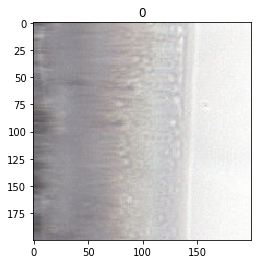

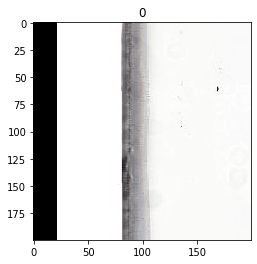

In [ ]:
print(X1_train.shape, X1_val.shape, X1_test.shape)
print('# train: %d, # val: %d, # test: %d' % (len(y_train), len(y_val), len(y_test)))
print('affected patches in train: %d, val: %d, test: %d ' % (sum(y_train), sum(y_val), sum(y_test)))

plt.imshow(X1_train[15])
plt.title(y_train[15])
plt.show()

plt.imshow(X2_train[15])
plt.title(y_train[15])
plt.show()

In [ ]:
def my_generator(X1, X2, y,data_argumentation):
  X1 = X1.astype(float)*(1./255)
  X2 = X2.astype(float)*(1./255)
  
  while True:
      idx = np.random.permutation(X1.shape[0])
      # data argumentation
      if data_argumentation:
        datagen = ImageDataGenerator(
            # rescale=1./255.,
            rotation_range=10, 
            width_shifft_range=0.1,
            height_shift_range=0.1
        )
      else:
        datagen = ImageDataGenerator()
    
      batches = datagen.flow(X1[idx], y[idx], batch_size=32)
      idx0 = 0
      for batch in batches:
          idx1 = idx0 + batch[0].shape[0]
          yield [batch[0], X2[idx[idx0:idx1]]], batch[1]
          idx0 = idx1
          if idx1 >= X1.shape[0]:
              break

def rescale01(x):
    x = x.astype(float)
    x /= 255.
    return x

preprocess_input = rescale01
      

train_generator = my_generator(X1_train, X2_train, y_train,True)
val_generator = my_generator(X1_val, X2_val, y_val,False)
test_generator = my_generator(X1_test, X2_test, y_test,False)

In [ ]:
# conv_base = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(299, 299, 3))


In [ ]:

# conv tower for input lev1
conv1 = Sequential([
    Conv2D(32, kernel_size=(5, 5), input_shape=(patch_size, patch_size, 3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), padding='same'),
    # # BatchNormalization(),
    # # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

])
in1 = conv1.input
out1 = conv1.output

# conv tower for input lev2
conv2 = Sequential([
    Conv2D(32, kernel_size=(5, 5), input_shape=(patch_size, patch_size, 3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), padding='same'),
    # # BatchNormalization(),
    # # Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
])

# rename layers to avoid name collisions

in2 = conv2.input
out2 = conv2.output

# merge conv outputs
merged = concatenate([out1, out2])
# average = GlobalAveragePooling2D(merged)
flat = Flatten()(merged)
dense1 = Dense(256, activation='relu')(flat)
drop1 = Dropout(.5)(dense1)
final_out = Dense(1, activation='sigmoid')(drop1)

# call model
model = Model([in1, in2], final_out)

model.summary()

print('Number of trainable layers in the model:', len(model.trainable_weights))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_8_input (InputLayer)     [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12_input (InputLayer)    [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 200, 200, 32) 2432        conv2d_8_input[0][0]             
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 200, 200, 32) 2432        conv2d_12_input[0][0]            
____________________________________________________________________________________________

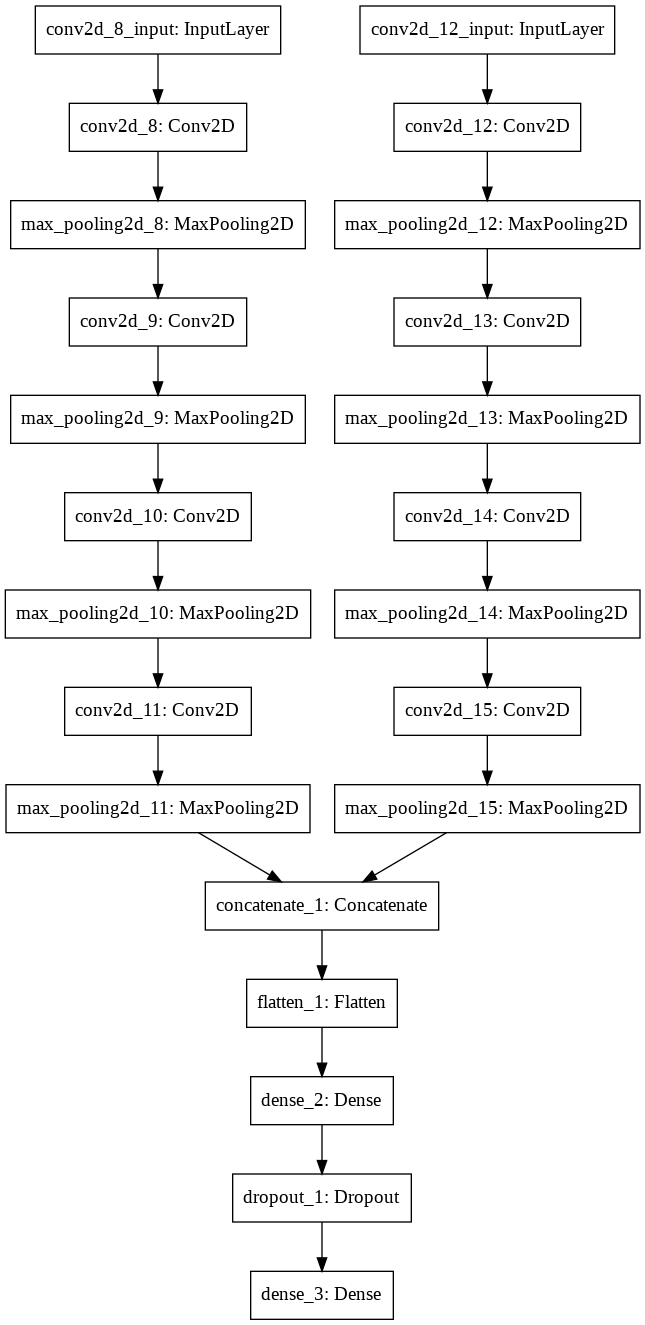

In [ ]:
# compile model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model.compile(optimizer=RMSprop(lr=1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# use early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               verbose=1)

# save checkpoints (in case GCC crashes mid-training)
#save_model = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')


# time model run
# start_time = time.time()/60
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps= 30,
    )
# train_time = time.time()/60 - start_time
# print('Time: %.2f min' % train_time)


# save model to disk
model_filename = model_name + '_MODEL.h5' 
model.save(model_filename)

# check if model is there
# !ls -hlt *.h5

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 30 steps
Epoch 1/10
100/100 [==============================] - 27s 269ms/step - loss: 0.6478 - accuracy: 0.6409 - val_loss: 0.5815 - val_accuracy: 0.6867
Epoch 2/10
100/100 [==============================] - 26s 255ms/step - loss: 0.5325 - accuracy: 0.7716 - val_loss: 0.5096 - val_accuracy: 0.7517
Epoch 3/10
100/100 [==============================] - 26s 255ms/step - loss: 0.4265 - accuracy: 0.8431 - val_loss: 0.4519 - val_accuracy: 0.7783
Epoch 4/10
100/100 [==============================] - 25s 254ms/step - loss: 0.3507 - accuracy: 0.8775 - val_loss: 0.4481 - val_accuracy: 0.7867
Epoch 5/10
100/100 [==============================] - 26s 258ms/step - loss: 0.3063 - accuracy: 0.8838 - val_loss: 0.4659 - val_accuracy: 0.8200
Epoch 6/10
100/100 [==============================] - 26s 255ms/step - loss: 0.2837 - accuracy: 0.8916 - val_loss: 0.4350 - val_accuracy: 0.8233
Epoch 7/10
100/100 [=================

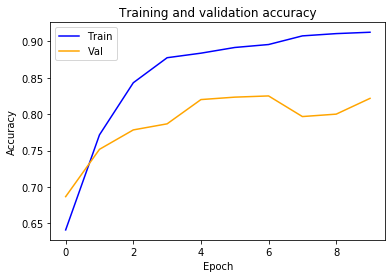

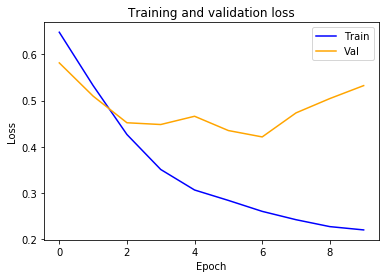

In [ ]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [ ]:
start_time = time.time()/60
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Time: %.2f min' % (time.time()/60 - start_time))
print('Test loss: %.4f, accuracy: %.4f' % (test_loss, test_acc))

  ...
    to  
  ['...']
Time: 0.02 min
Test loss: 0.3658, accuracy: 0.8760


In [ ]:
def get_patches_predict(slide, tumor_mask, lev, x0, y0, patch_size):
    downsample_factor = 2**lev
    patch_image = read_slide(slide,
                             x = x0-(patch_size//2)*downsample_factor,
                             y = y0-(patch_size//2)*downsample_factor, 
                             level = lev,
                             width = patch_size,
                             height = patch_size)
    
    patch_mask = read_slide(tumor_mask,
                            x = x0-(patch_size//2)*downsample_factor,
                            y = y0-(patch_size//2)*downsample_factor, 
                            level = lev,
                            width = patch_size,
                            height = patch_size)

    # 1 channel is enough for the mask
    patch_mask = patch_mask[:,:,0]
    
    return patch_image, patch_mask

In [ ]:
from tqdm import tqdm

In [ ]:
def get_heatmap(f_num, lev1, lev2, patch_size, patch_centre):
  """ Generate a heatmap at level 7 by sliding a window in x and y in and extracting 
  patches at the model zoom level for every pixel at level 7

  inputs:
  - f_num: str, slide number
  - lev1: int, target zoom level for the patches, between 0 and 7 - higher resolution: lev1<lev2
  - lev2: int, target zoom level for the patches, between 0 and 7 - lower resolution
  - patch_size: int, usually 299
  - patch_centre: int, usually 128

  outputs:
  - heatmap: array of floats, heatmap at level 7
  - max_heatmap: maximum of the heatmap
  outputs: evaluation scores for imbalanced classification (from sklearn.metric):
  - precision: float in [0, 1]
  - recall: float in [0, 1]
  - f1: float in [0, 1]
  - roc_auc: float in [0, 1]
  - avg_prec: float in [0, 1]
  - save a plot of the heatmap
  """
    
  # ---------------------------------------------------------------------------
  # get the slide at level 7 and plot it

  # file paths
  slide_path = image_path+'tumor_'+f_num+'.tif'
  tumor_mask_path = mask_path+'tumor_'+f_num+'_mask.tif'

  print(slide_path, tumor_mask_path)

  # get slide objects with OpenSlide
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  # read level 7 RBG image
  slide_image_lev7 = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=7, 
                           width=slide.level_dimensions[7][0], 
                           height=slide.level_dimensions[7][1])

  # read level 7 tumor mask
  mask_image_lev7 = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=7, 
                          width=tumor_mask.level_dimensions[7][0], 
                          height=tumor_mask.level_dimensions[7][1])

  mask_image_lev7 = mask_image_lev7[:,:,0]

  # get tissue mask
  tissue_pixels_lev7 = find_tissue_pixels(slide_image_lev7)
  tissue_regions_lev7 = apply_mask(slide_image_lev7, tissue_pixels_lev7)

  # plot images and masks
  fig, axes = plt.subplots(1,3, figsize=(20,10), dpi=100)
  axes[0].imshow(slide_image_lev7)
  axes[1].imshow(mask_image_lev7)
  axes[2].imshow(tissue_regions_lev7)
  plt.show()
    
    
  # ---------------------------------------------------------------------------
  # slide through the image and fill in the heatmap

  start_time = time.time()/60

  # init the heatmap with zeros (size of level 7)
  heatmap = np.zeros(slide_image_lev7.shape[:2])

  true_class, pred_class = [], []

  # stride at level 7
  stride = 2**lev1

  # offset for correctly setting the values in heatmap
  heatmap_offset = stride//2


  heat_x = []
  heat_y = []

  # collect a batches of 1000 patches and make a prediction on that batch (done to speed up)
  # for each zoom level
  strip_of_patches_lev1, strip_of_patches_lev2 = [], []

  print(slide.level_dimensions[7][0], slide.level_dimensions[7][1])

  # slide in x by stride 
  for x in range(stride*2, slide.level_dimensions[7][1]-3*stride, stride):

    if x%(10*stride)==0:
      print('|', x, end=': ')
      if x%(10*10*stride)==0:
        print()

    # slide in y by stride 
    for y in range(stride*2, slide.level_dimensions[7][0]-3*stride, stride):

      # convert level 7 coordinates to level 0
      x0 = x*(2**7)
      y0 = y*(2**7)

      # only do prediction if the pixel at level 7 is a tissie (i.e. >0.8 greyscale)
      if tissue_regions_lev7[x, y, 0]==1:

        # keep level 7 coordinates
        heat_x.append(x)
        heat_y.append(y)

        # get patch CENTERED at x0, y0
        patch_image_lev1, patch_mask_lev1 = get_patches_predict(slide, tumor_mask, lev1, y0, x0, patch_size)
        # append to the batch of patches
        strip_of_patches_lev1.append(patch_image_lev1)

        # get true label
        has_cancer = check_patch_centre(patch_mask_lev1, patch_centre)
        true_class.append(has_cancer)

        patch_image_lev2, patch_mask_lev2 = get_patches_predict(slide, tumor_mask, lev2, x0, y0, patch_size)
        strip_of_patches_lev2.append(patch_image_lev2)

        # if 500 patches collected, make a prediction for them and append the precictions
        if len(strip_of_patches_lev1)==500:

          pred_class.extend(model.predict([preprocess_input(np.asarray(strip_of_patches_lev1)), preprocess_input(np.asarray(strip_of_patches_lev2))]))
          print(len(pred_class))
          # reset strips of patches
          strip_of_patches_lev1 = []
          strip_of_patches_lev2 = []

  pred_class.extend(model.predict([preprocess_input(np.asarray(strip_of_patches_lev1)), preprocess_input(np.asarray(strip_of_patches_lev2))]))

  if lev1==0:

    for i in range(len(pred_class)):
      heatmap[heat_x[i], heat_y[i]] = pred_class[i]
  else:

    for i in range(len(pred_class)):
      heatmap[heat_x[i]-heatmap_offset:heat_x[i]+heatmap_offset, heat_y[i]-heatmap_offset:heat_y[i]+heatmap_offset] = pred_class[i]
    
  heat_time = time.time()/60 - start_time

  max_heatmap = np.max(heatmap)

  print()
  print('Heatmap max: %.3f' % max_heatmap)
  print()
  roc_auc = roc_auc_score(np.array(true_class) == 1, pred_class)
  avg_prec = average_precision_score(np.array(true_class) == 1, pred_class)
  precision = precision_score(np.array(true_class) == 1, np.array(pred_class) >= 0.5)
  recall = recall_score(np.array(true_class) == 1, np.array(pred_class) >= 0.5)
  f1 = f1_score(np.array(true_class) == 1, np.array(pred_class) >= 0.5)

  print('Precision score: %.3f' % precision)
  print('Recall score: %.3f' % recall)
  print('F1 score: %.3f' % f1)
  print('ROC AUC score: %.3f' % roc_auc)
  print('Average precision score: %.3f' % avg_prec)


  fig, axes = plt.subplots(1,2, figsize=(20,20), dpi=100)
    
  cmap = plt.cm.viridis
  v_min, v_max = 0, 1
  colors = Normalize(v_min, v_max)(mask_image_lev7)
  colors = cmap(colors)
  colors[..., -1] = mask_image_lev7/np.max(mask_image_lev7)

  a = axes[0]
  a.imshow(slide_image_lev7)
  a.imshow(colors, cmap='viridis', vmin=v_min, vmax=v_max, alpha=0.8)
  a.set_xticks([]), axes[0].set_yticks([])
  a.set_title('TRUE (tumor as labeled by a pathologist), slide num: ' + f_num)

    
  a = axes[1]

  # normalize the mask between 0 and 1
  v_min, v_max = 0, 1
  colors = Normalize(v_min, v_max)(heatmap)
  colors = cmap(colors)
  colors[..., -1] = heatmap/np.max(heatmap)
  a.imshow(slide_image_lev7)
  a.imshow(colors, cmap='viridis', vmin=v_min, vmax=v_max, alpha=0.8)
  a.set_xticks([]), axes[1].set_yticks([])
  a.set_title('PRED (mult model lev %d - %d), slide num: %s | max: %.2f,  prec: %.2f, rec: %.2f, f1: %.2f, , roc auc: %.2f, avg prec: %.2f, time: %.2f' %
              (lev1, lev2, f_num, max_heatmap,  precision, recall, f1, roc_auc, avg_prec, heat_time))

  plt.show()

  fig.savefig(model_name+'_pred_'+f_num+'.pdf', bbox_inches='tight')
  
  return heatmap, max_heatmap, precision, recall, f1, roc_auc, avg_prec

/content/drive/My Drive/Colab Notebooks/final_project/image/tumor_031.tif /content/drive/My Drive/Colab Notebooks/final_project/mask/tumor_031_mask.tif


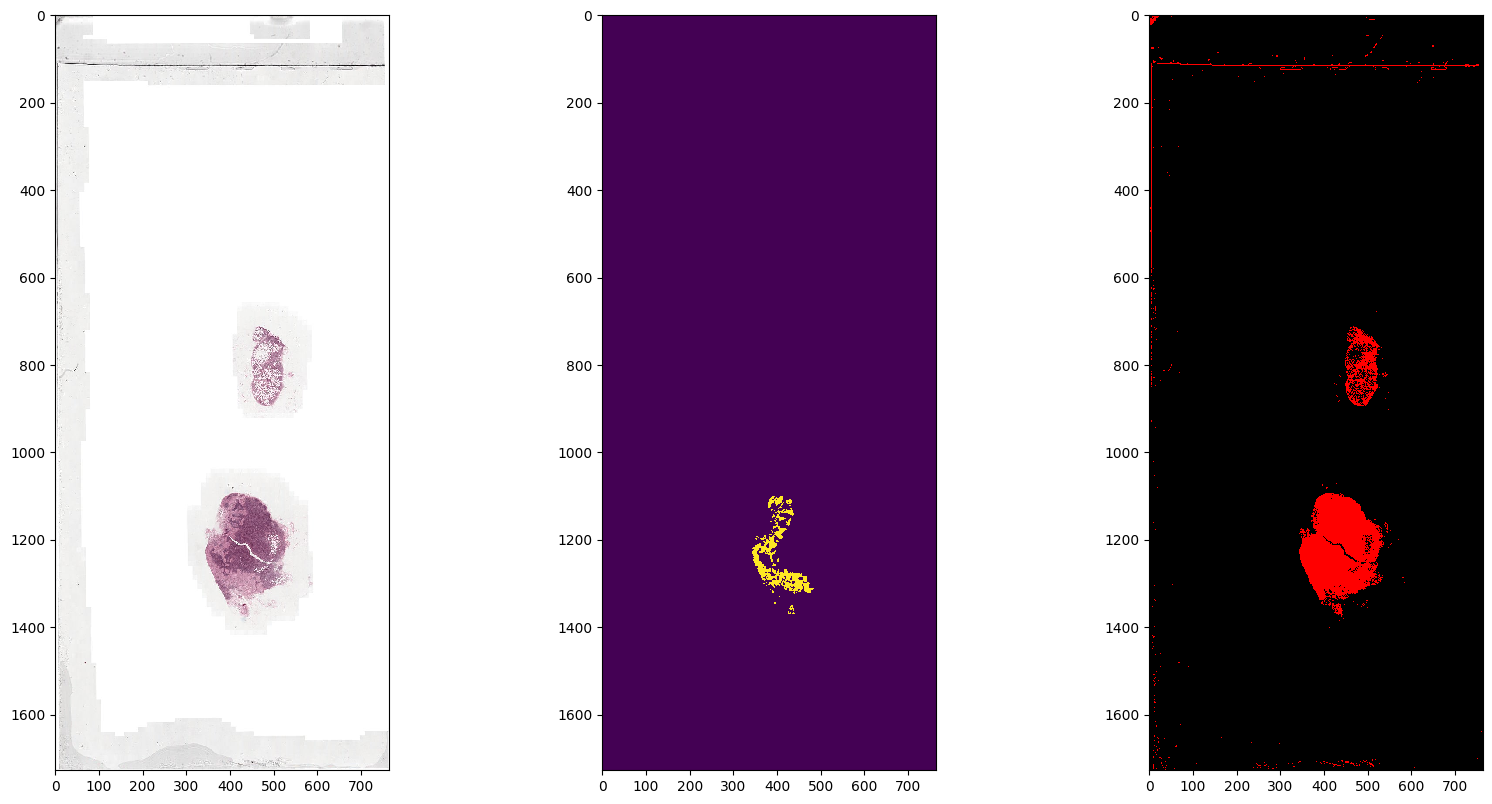

764 1728
| 20: | 40: | 60: | 80: | 100: 500
| 120: | 140: | 160: | 180: | 200: 
| 220: | 240: | 260: | 280: | 300: | 320: | 340: | 360: | 380: | 400: 
| 420: | 440: | 460: | 480: | 500: | 520: 1000
| 540: | 560: | 580: | 600: 
| 620: | 640: | 660: | 680: | 700: | 720: | 740: 1500
| 760: | 780: | 800: 
2000
| 820: | 840: 2500
| 860: | 880: 3000
| 900: | 920: | 940: | 960: | 980: | 1000: 
| 1020: | 1040: | 1060: | 1080: | 1100: 3500
| 1120: 4000
| 1140: 4500
| 1160: 5000
5500
| 1180: 6000
| 1200: 
6500
7000
| 1220: 7500
8000
| 1240: 8500
| 1260: 9000
9500
| 1280: 10000
| 1300: 10500
11000
| 1320: | 1340: | 1360: | 1380: | 1400: 
| 1420: | 1440: | 1460: | 1480: | 1500: | 1520: | 1540: 11500
| 1560: | 1580: | 1600: 
| 1620: | 1640: | 1660: | 1680: | 1700: | 1720: 
Heatmap max: 0.990

Precision score: 0.383
Recall score: 0.428
F1 score: 0.404
ROC AUC score: 0.761
Average precision score: 0.375


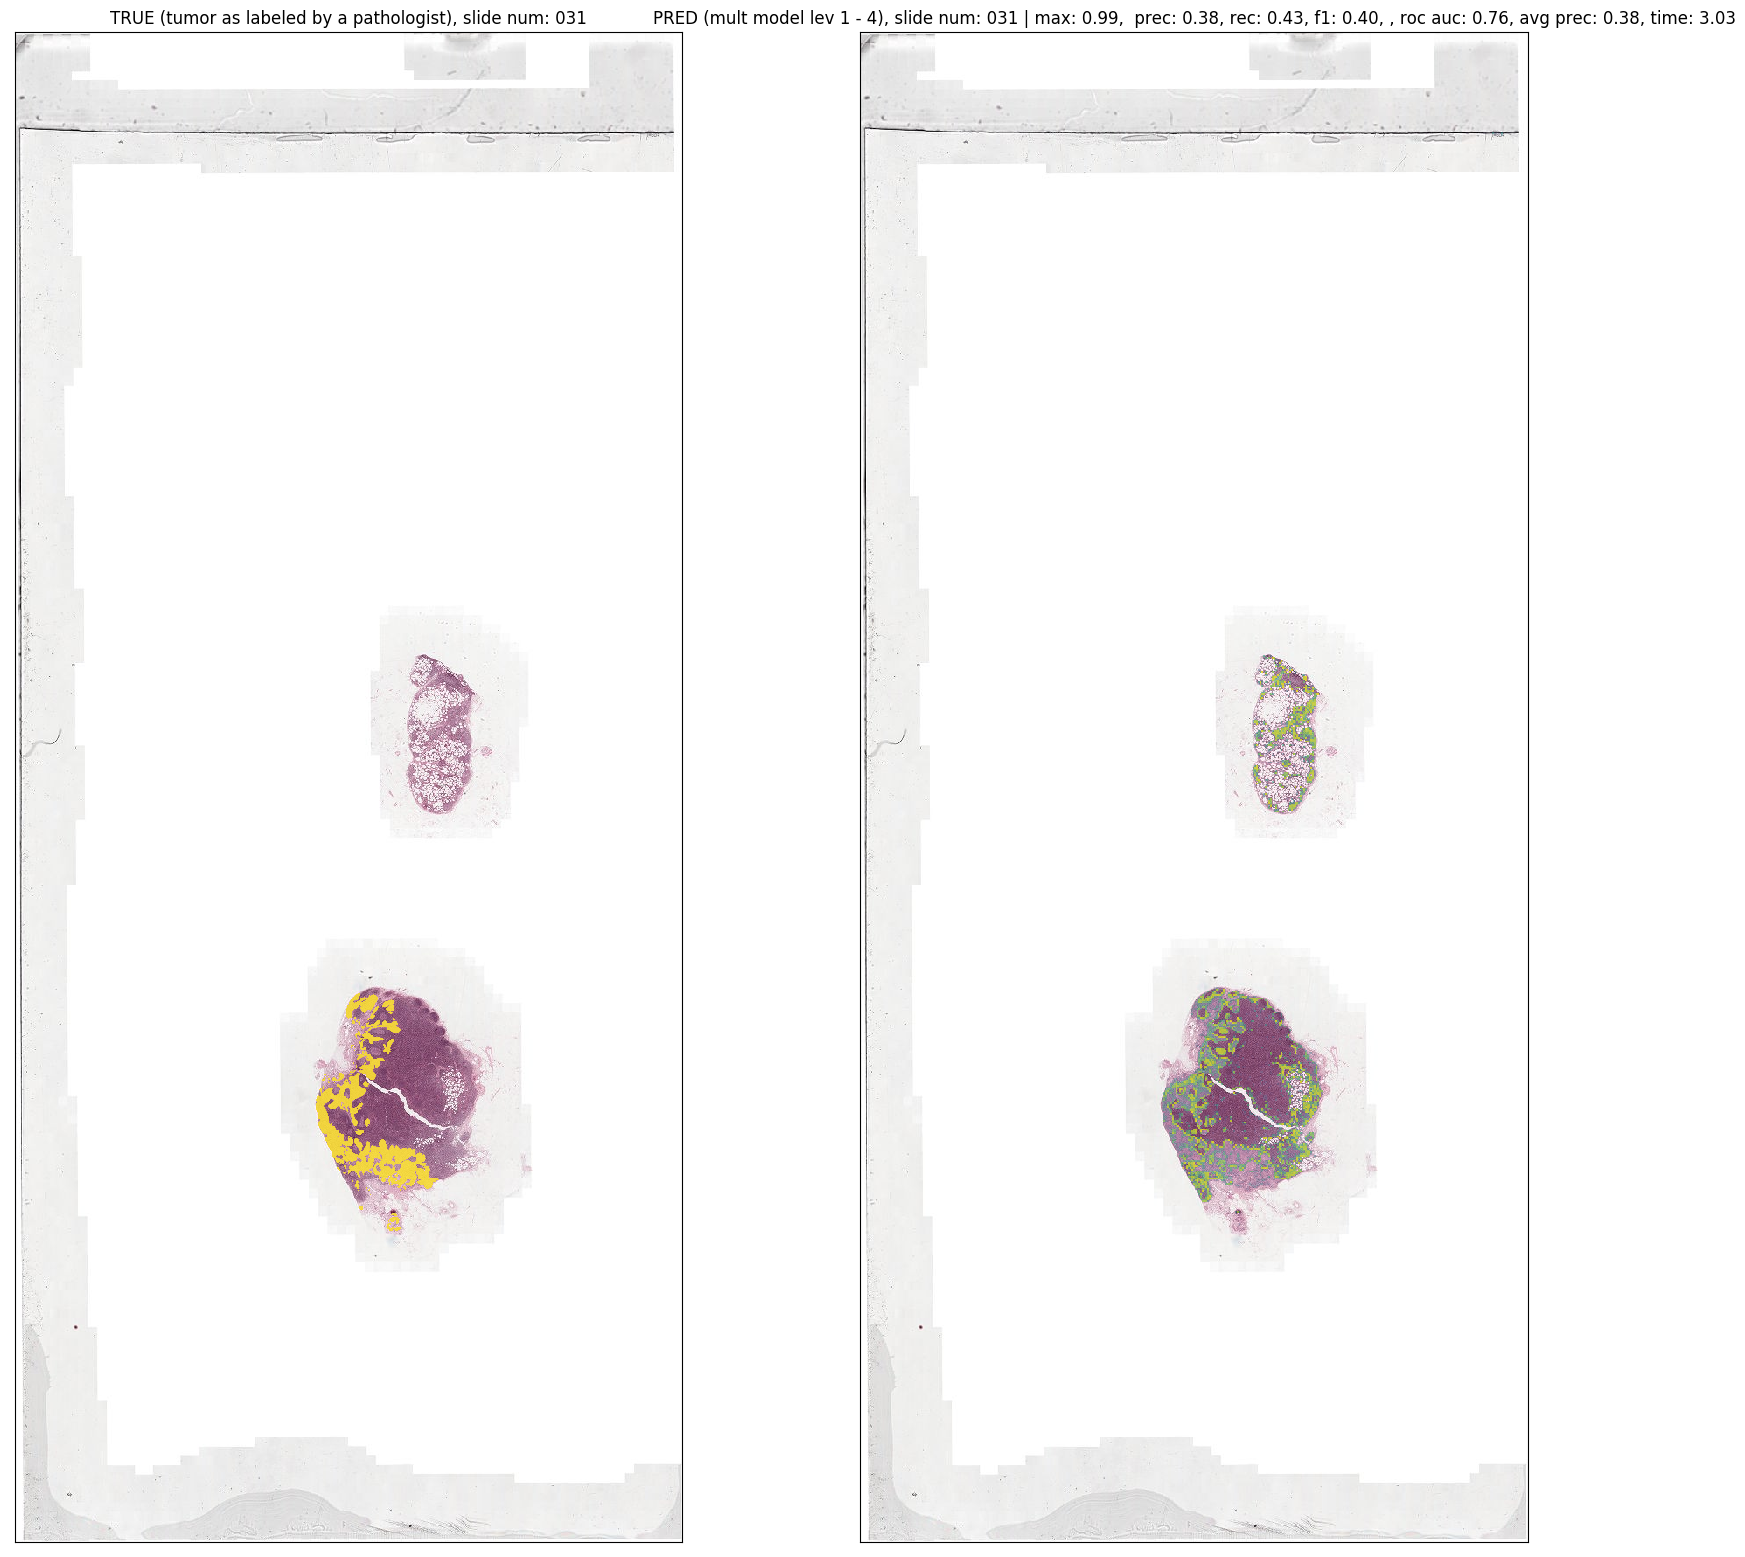

In [ ]:
slides_to_heatmap = ['031']

for f_num in slides_to_heatmap:
  heatmap, max_heatmap, precision, recall, f1, roc_auc, avg_prec = get_heatmap(f_num, lev1, lev2, patch_size, patch_centre)